In [1]:
import numpy as np
import matplotlib.pyplot as plt

from random import randrange

import torch
from torch.nn import Module
from torch.distributions import Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily

In [2]:
pile_sampler = Categorical(torch.tensor([1/2 , 1/2]))
normal_init = MultivariateNormal(torch.tensor([[2,2],[2,6]]).float(), 0.1*torch.stack([torch.eye(2), torch.eye(2)]))
normal_target = MultivariateNormal(torch.tensor([[6,2],[6,6]]).float(), 0.1*torch.stack([torch.eye(2), torch.eye(2)]))
sampler_init = MixtureSameFamily(pile_sampler, normal_init)
sampler_target = MixtureSameFamily(pile_sampler, normal_target)

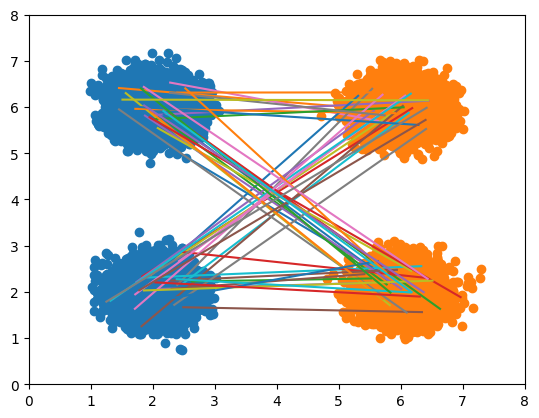

In [3]:
samples_init=sampler_init.sample([10000])
samples_target=sampler_target.sample([10000])

plt.scatter(samples_init[:,0].numpy(), samples_init[:,1].numpy())
plt.scatter(samples_target[:,0].numpy(), samples_target[:,1].numpy())
plt.xlim(0, 8)
plt.ylim(0, 8)
pairs_1 = torch.stack([samples_init, samples_target], axis=1)
for pair in range(50):
    plt.plot([pairs_1[pair][0][0], pairs_1[pair][1][0]], [pairs_1[pair][0][1], pairs_1[pair][1][1]])

In [4]:
def rbf_kernel(a, b, h):
    norm = torch.norm(a-b, dim=-1, keepdim=False)
    log_kappa = (-1.) * norm.pow(2) / (2. * h)

    return log_kappa

class NW(Module):
    def __init__(self, pairs, sample_size, bandwidth=1.):
        super().__init__()
        self.pairs = pairs
        self.number_of_pairs = self.pairs.shape[0]
        self.sample_size = sample_size
        self.h = bandwidth

    def forward(self, x_input, t):
        indices = torch.randperm(self.number_of_pairs)[:self.sample_size]
        pi_0_sample = self.pairs[indices, 0].detach().clone()
        pi_1_sample = self.pairs[indices, 1].detach().clone()
        pi_0_sample = pi_0_sample[None, :, :].repeat(x_input.shape[0], 1, 1)
        pi_1_sample = pi_1_sample[None, :, :].repeat(x_input.shape[0], 1, 1)
        x_input = x_input[:, None, :].repeat(1, self.sample_size, 1)
        x_t = t * pi_1_sample + (1.-t) * pi_0_sample
        log_kappa = rbf_kernel(x_t.detach().clone(), x_input.detach().clone(), self.h)
        omega = torch.softmax(log_kappa, dim=-1) * self.sample_size  ### multiplying self.sample_size because the denominator in softmax is sum, not mean

        v = (pi_1_sample - x_input) / (1.-t) * omega[:,:,None]
        v = v.mean(dim=1, keepdim=False)

        return v

In [5]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model

    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0)

        dt = 1./num_steps
        z = z0.clone()
        for i in range(num_steps):
            t = i /num_steps
            pred = self.v_model(z, t)
            z = z.clone() + pred * dt

            trajectory.append(z.clone())

        return trajectory


In [6]:
def draw_plot(rectified_flow, z0, z1, num_steps):
  traj = rectified_flow.sample_ode(z0=z0, num_steps=num_steps)
  
  plt.figure(figsize=(4,4))
  plt.xlim(0,8)
  plt.ylim(0,8)
    
  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(0,8)
  plt.ylim(0,8)
  plt.axis('equal')
  for i in range(120):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

In [25]:
rectified_flow_1 = RectifiedFlow(v_model=NW(pairs=pairs_1, sample_size=4096, bandwidth=0.001))

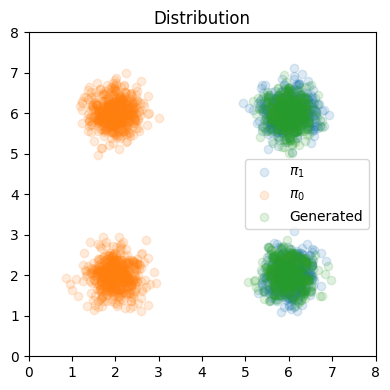

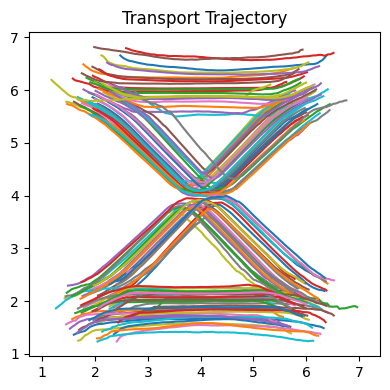

In [26]:
draw_plot(rectified_flow_1, z0=sampler_init.sample([1000]), z1=sampler_target.sample([1000]), num_steps=100)

In [10]:
flow_1 = rectified_flow_1.sample_ode(samples_init, 100)
pairs_2 = torch.stack([samples_init, flow_1[:][-1]], axis= 1)

In [11]:
v_model_2 = NW(pairs_2, 4000, 0.001)
rectified_flow_2 = RectifiedFlow(v_model_2)

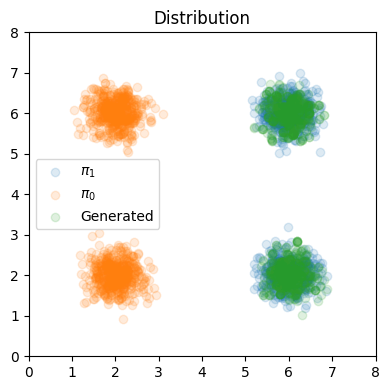

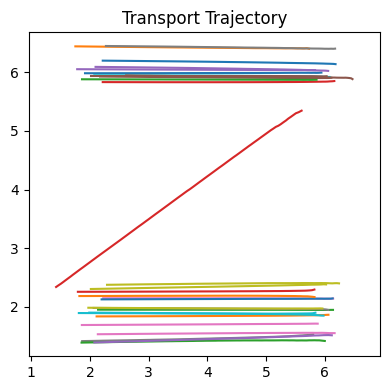

In [12]:
draw_plot(rectified_flow_2, z0=sampler_init.sample([1000]), z1=sampler_target.sample([1000]), num_steps=100)

In [13]:
flow_2 = rectified_flow_2.sample_ode(samples_init, 100)
pairs_3 = torch.stack([samples_init, flow_2[:][-1]], axis= 1)

In [14]:
v_model_3 = NW(pairs_3, 4000, 0.001)
rectified_flow_3 = RectifiedFlow(v_model_3)

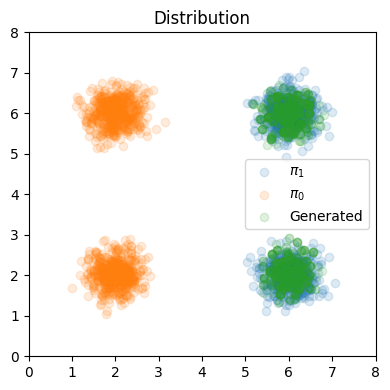

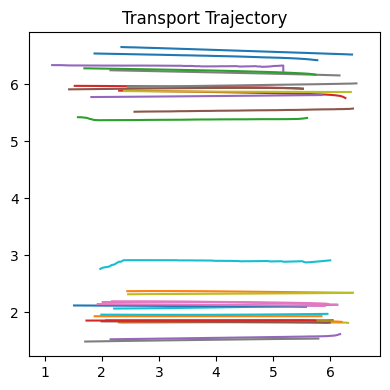

In [15]:
draw_plot(rectified_flow_3, z0=sampler_init.sample([1000]), z1=sampler_target.sample([1000]), num_steps=100)